# Train Full Dataset

Up until this point I was training on 100K "no fire" data points and 92K "fire" data points using SciKit Learn to do a 30% train/test split. This worked fairly well to iterate on with the different tree and NN models. In order to run the whole data set, 28MM "no fire" data points and 92K "fire" data points, I needed to optimize a few things.

The first problem I encountered was just trying to load 28MM rows from Sqlite into a Pandas Dataframe. I ran into issues pretty quickly running out of memory. The initial load took 3 hours to load up the Pandas DataFrame and took 55 GB of memory using a Jupyter Notebook. I realized I needed to reduce my memory footprint.

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb

import queries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
df = queries.get_df()

df_encoded = pd.get_dummies(df.drop(['fire_size_class'], axis=1), columns=['month'])
columns=df_encoded.columns.values
scaler = StandardScaler()
scaler.fit(df_encoded)

X = scaler.transform(df_encoded)
y = df.fire_size_class > ''

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = xgb.XGBClassifier(
    seed=42,
    use_label_encoder=False,
    objective='binary:logistic',
    n_estimators=200,
    max_depth=9,
    learning_rate=0.2,
    gamma=0.2,
    eval_metric='logloss',
    colsample_bytree=0.4,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
all_recall = recall_score(y_test, y_pred)

print(f'Recall for all columns: {all_recall}')

Recall for all columns: 0.880448372494072


### 1. Dropping Highly Correlated Columns

I started by identifing columns I could drop from the SQL query. I first used the correlation heatmap to identify features that were highly correlated like `wind min/max/range` at `10m/50m`, `temp min/max` at `2m`, `temp 0m`, `aspect unkonwn`, `cultivated land` and `nutrient retention`.

In [15]:
correlated_cols = ['temp_max_2m', 'temp_min_2m', 'temp_0m', 'temp_wet_bulb_2m', 'wind_max_10m', 'wind_min_10m', 'wind_range_10m', 'wind_max_50m', 'wind_min_50m', 'wind_range_50m', 'aspect_unknown', 'cultivated_land', 'nutrient_retention']
df_no_corr = df.drop(correlated_cols, axis=1)
df_no_corr_encoded = pd.get_dummies(df_no_corr.drop(['fire_size_class'], axis=1), columns=['month'])
columns=df_no_corr_encoded.columns.values
scaler = StandardScaler()
scaler.fit(df_no_corr_encoded)

X_no_corr = scaler.transform(df_no_corr_encoded)
y_no_corr = df_no_corr.fire_size_class > ''

X_no_corr_train, X_no_corr_test, y_no_corr_train, y_no_corr_test = train_test_split(X_no_corr, y_no_corr, random_state=42)

model = xgb.XGBClassifier(
    seed=42,
    use_label_encoder=False,
    objective='binary:logistic',
    n_estimators=200,
    max_depth=9,
    learning_rate=0.2,
    gamma=0.2,
    eval_metric='logloss',
    colsample_bytree=0.4,
)

model.fit(X_no_corr_train, y_no_corr_train)
y_no_corr_pred = model.predict(X_no_corr_test)
no_corr_recall = recall_score(y_no_corr_test, y_no_corr_pred)

print(f'Recall after removing highly correlated columns: {no_corr_recall}')

Recall after removing highly correlated columns: 0.8914421211467989


### 2. Dropping Columns that Make Recall Worse

Next I tried removing features one at a time and seeing if the removed features would improve the recall score. Dropping individual columns didn't seem to make much difference.

In [11]:
drop_cols = []
best_recall = all_recall

# Remove features one at a time to see if the feature is valuable
for i in range(X_train.shape[1]):
    if i not in drop_cols:
        drop_cols_try = drop_cols + [i]
        X_train_try = np.delete(X_train, drop_cols_try, axis=1)

        model = xgb.XGBClassifier(
            seed=42,
            use_label_encoder=False,
            objective='binary:logistic',
            n_estimators=200,
            max_depth=9,
            learning_rate=0.2,
            gamma=0.2,
            eval_metric='logloss',
            colsample_bytree=0.4,
        )

        model.fit(X_train_try, y_train)

        X_test_try = np.delete(X_test, drop_cols_try, axis=1)
        y_pred = model.predict(X_test_try)

        recall = recall_score(y_test, y_pred)

        print(f'Recall for dropping {i} col: {recall}')

        if recall > best_recall:
            drop_cols.append(i)
            print(f'Drop cols {drop_cols}')
            best_recall = recall

print(f'Columns to drop: {drop_cols}')


Recall for dropping 0 col: 0.8638068549256305
Recall for dropping 1 col: 0.864539771502479
Recall for dropping 2 col: 0.8568225910756628
Recall for dropping 3 col: 0.8775167061866782
Recall for dropping 4 col: 0.8738521233024359
Recall for dropping 5 col: 0.8789394266005605
Recall for dropping 6 col: 0.8776029316663074
Recall for dropping 7 col: 0.8782927355033412
Recall for dropping 8 col: 0.8796723431774089
Recall for dropping 9 col: 0.8791549902996335
Recall for dropping 10 col: 0.8776891571459366
Recall for dropping 11 col: 0.8812675145505496
Drop cols [11]
Recall for dropping 12 col: 0.8798447941366674
Recall for dropping 13 col: 0.8806639361931451
Recall for dropping 14 col: 0.8816124164690666
Drop cols [11, 14]
Recall for dropping 15 col: 0.8841129553783142
Drop cols [11, 14, 15]
Recall for dropping 16 col: 0.8825177840051736
Recall for dropping 17 col: 0.8784651864625997
Recall for dropping 18 col: 0.8833369260616513
Recall for dropping 19 col: 0.8835093770209097
Recall for dro

In [13]:
print(f'Columns to drop: {np.take(columns, drop_cols)}')

Columns to drop: ['temp_range_2m' 'wind_50m' 'drought_score']


### 3. Save numpy Binaries Outside of Jupyter

Next I broke out the loading up of the train and test data into a `trainer/export.py` Python script that serializes the `X_train`, `X_test`, `y_train` and `y_test` into binary numpy array files so that I could re-train without having to wait for the Sqlite data to load up. I also ran this outside of the Jupyter Notebook to free up some memory. The resulting binary files took over 3 hours to generate and were `12GB`, `700MB`, `27M` and `2MB` respectively.

In [12]:
# python trainer/export.py
# => X_train, X_test, y_train, y_test

### 4. Train Model Outside Jupyter 

I did the same for the `trainier/train.py` standalone Python script that loaded up the binaries and generated either a LightGBM or XGBoost model pickle file. Generating the XGBoost model picle took about an hour.

In [16]:
# python trainer/train.py xgb
# => xgb_model.pickle

# python trainer/train.py lgbm
# => lgbm_model.pickle

### 5. Test XGBoost and LightGBM

In [18]:
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')

In [22]:
xgb_model = joblib.load(f'./xgb_model.pickle')

y_pred_xgb = xgb_model.predict(X_test)

print(f'XGBoost Classification Report')
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1486756
           1       0.01      0.57      0.02      2438

    accuracy                           0.90   1489194
   macro avg       0.50      0.73      0.48   1489194
weighted avg       1.00      0.90      0.94   1489194



58


Text(0.5, 1.0, 'XGBoost feature importances')

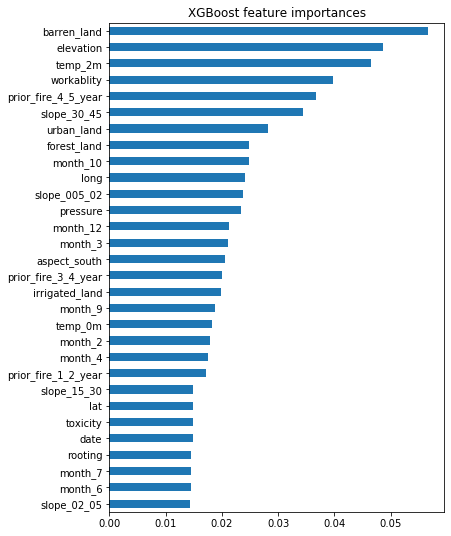

In [32]:
columns = pd.get_dummies(df.drop(['fire_size_class', 'wind_max_10m','wind_min_10m','wind_range_10m','wind_50m','wind_max_50m','wind_min_50m','wind_range_50m', 'aspect_unknown', 'cultivated_land', 'nutrient_retention'], axis=1), columns=['month']).columns
print(len(columns))
importances_xgb = xgb_model.feature_importances_
importances_xgb = pd.Series(importances_xgb, index=columns).sort_values().tail(30)

fig, ax = plt.subplots()
fig.set_figheight(9)
importances_xgb.plot.barh(ax=ax)
ax.set_title('XGBoost feature importances')

In [23]:
lgbm_model = joblib.load(f'./lgbm_model.pickle')

y_pred_lgbm = lgbm_model.predict(X_test)

print(f'LightGBM Classification Report')
print(classification_report(y_test, y_pred_lgbm))

LightGBM Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80   1486756
           1       0.00      0.68      0.01      2438

    accuracy                           0.67   1489194
   macro avg       0.50      0.68      0.41   1489194
weighted avg       1.00      0.67      0.80   1489194

